# Low-Discrepancy Sequence vs. Product Potential Optimization

This notebook compares standard low-discrepancy sequences (Sobol', Halton, Latin Hypercube) with point configurations optimized to minimize the component-wise product potential energy:

$$ E = \sum_{i \ne j} \prod_{k=0}^{d-1} |x_i[k] - x_j[k]|^{-\alpha} $$

We prioritize 2D visualization to observe the structure of the points.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
from low_discrepancy_optimizer import LowDiscrepancyGenerator, ProductPotentialOptimizer

%matplotlib inline

In [2]:
def analyze_configurations(d, n, alpha=2.0, repulsive=False):
    print(f"--- Analyzing Dimension d={d}, Points n={n} ---")
    
    minima = np.zeros(d)
    maxima = np.ones(d)
    
    # Generators
    gen = LowDiscrepancyGenerator(d, minima, maxima)
    
    configs = {}
    
    # 1. Random
    configs['Random'] = gen.random(n)
    
    # 2. Sobol
    try:
        configs['Sobol'] = gen.sobol(n)
    except Exception as e:
        print(f"Sobol generation failed (possibly n not power of 2 warning): {e}")
        configs['Sobol'] = np.random.rand(n, d) # Fallback

    # 3. Halton
    configs['Halton'] = gen.halton(n)
    
    # 4. Latin Hypercube
    configs['LHS'] = gen.latin_hypercube(n)
    
    # 5. Optimized (Product Potential)
    optimizer = ProductPotentialOptimizer(d, n, minima, maxima, alpha=alpha, repulsive_boundary=repulsive)
    print("Optimizing...")
    start_time = time.time()
    configs['Optimized'] = optimizer.optimize(maxiter=2000)
    print(f"Optimization done in {time.time() - start_time:.2f}s")
    
    # 6. Optimized (Repulsive Boundary)
    optimizer_rep = ProductPotentialOptimizer(d, n, minima, maxima, alpha=alpha, repulsive_boundary=True)
    print("Optimizing (Repulsive Boundary)...")
    start_time = time.time()
    configs['Optimized Repulsive'] = optimizer_rep.optimize(maxiter=2000)
    print(f"Repulsive Optimization done in {time.time() - start_time:.2f}s")
    
    # Compute Energies
    energies = {}
    # For energy comparison, use the same optimizer instance (it holds the energy func)
    for name, X in configs.items():
        energies[name] = optimizer.compute_energy(X.flatten())
        print(f"{name} Energy: {energies[name]:.4e}")
        
    return configs, energies

## 2D Comparison (Priority)

--- Analyzing Dimension d=2, Points n=64 ---
Optimizing...
Optimization done in 4.04s
Optimizing (Repulsive Boundary)...
Repulsive Optimization done in 4.12s
Random Energy: 1.4013e+10
Sobol Energy: 1.8907e+08
Halton Energy: 4.5156e+07
LHS Energy: 4.1639e+08
Optimized Energy: 3.8407e+07
Optimized Repulsive Energy: 9.1102e+07


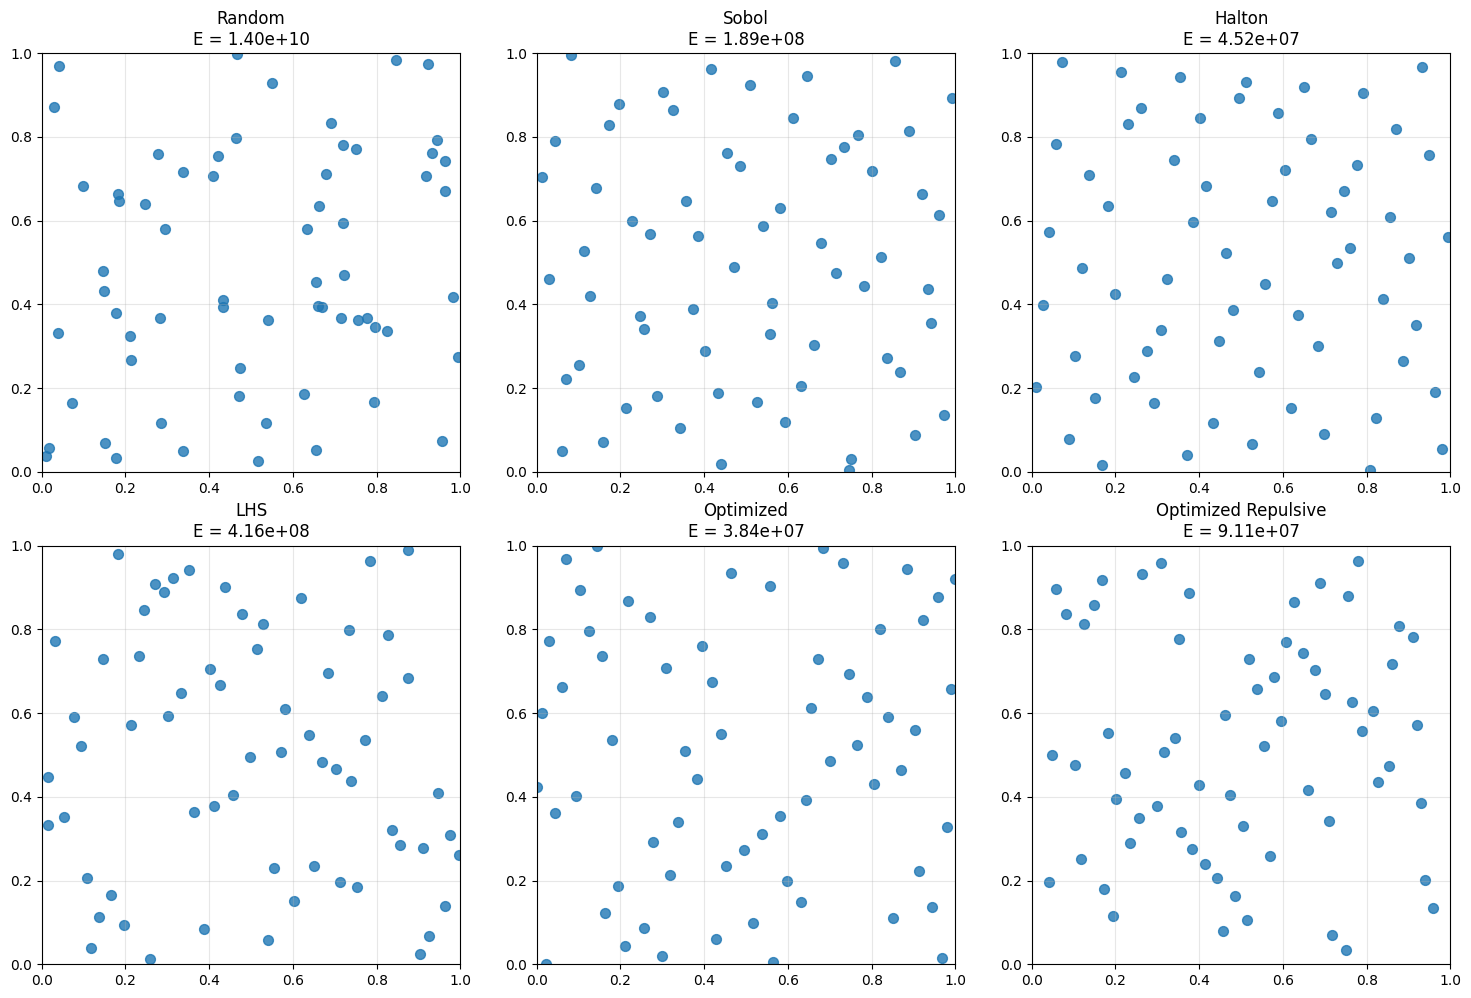

In [3]:
d = 2
n = 64  # Good number for visibility
configs_2d, energies_2d = analyze_configurations(d, n)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

titles = ['Random', 'Sobol', 'Halton', 'LHS', 'Optimized', 'Optimized Repulsive']

for i, title in enumerate(titles):
    ax = axes[i]
    X = configs_2d[title]
    E = energies_2d[title]
    
    ax.scatter(X[:, 0], X[:, 1], s=50, alpha=0.8)
    ax.set_title(f"{title}\nE = {E:.2e}")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

# Hide last empty subplot
# axes[-1].axis('off')  # All 6 used now

plt.tight_layout()
plt.show()

## 1D Comparison

--- Analyzing Dimension d=1, Points n=20 ---
Optimizing...
Optimization done in 0.12s
Random Energy: 1.2653e+05
Sobol Energy: 4.2072e+04
Halton Energy: 3.0577e+04
LHS Energy: 7.4760e+04
Optimized Energy: 2.0407e+04


/Users/sergei/articles/design_ml/low_discrepancy_optimizer.py:32: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = sampler.random(n)


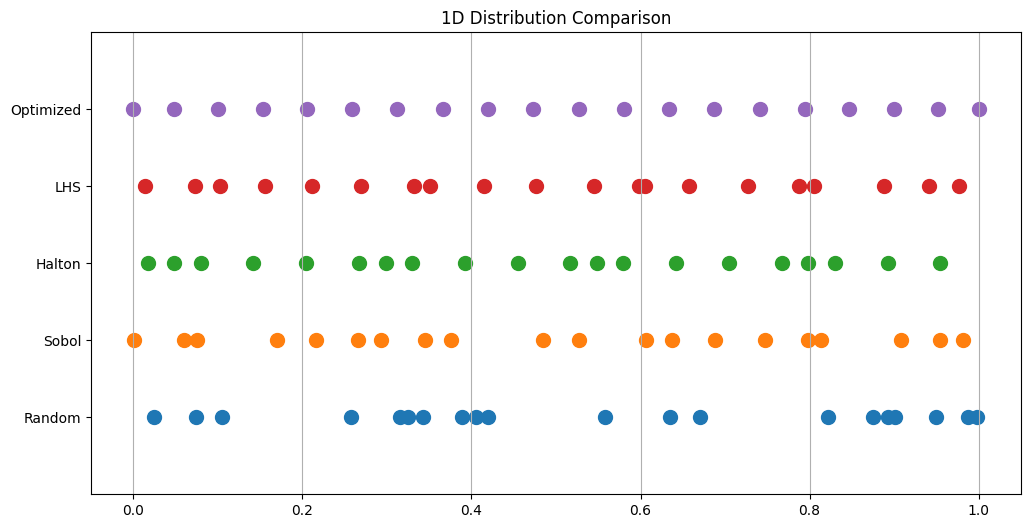

In [4]:
d = 1
n = 20
configs_1d, energies_1d = analyze_configurations(d, n)

fig, ax = plt.subplots(figsize=(12, 6))

y_offsets = range(len(configs_1d))
labels = list(configs_1d.keys())

for i, label in enumerate(labels):
    X = configs_1d[label]
    ax.scatter(X, np.full_like(X, i), s=100, label=label)

ax.set_yticks(range(len(labels)))
ax.set_yticklabels(labels)
ax.set_ylim(-1, len(labels))
ax.grid(True, axis='x')
ax.set_title("1D Distribution Comparison")
plt.show()

## 3D Comparison

In [5]:
d = 3
n = 100
configs_3d, energies_3d = analyze_configurations(d, n)

for name in ['Random', 'Sobol', 'Optimized']:
    X = configs_3d[name]
    fig = go.Figure(data=[
        go.Scatter3d(
            x=X[:,0], y=X[:,1], z=X[:,2],
            mode='markers',
            marker=dict(size=5, opacity=0.8)
        )
    ])
    fig.update_layout(title=f"3D - {name} (E={energies_3d[name]:.2e})")
    fig.show()

--- Analyzing Dimension d=3, Points n=100 ---
Optimizing...


/Users/sergei/articles/design_ml/low_discrepancy_optimizer.py:32: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = sampler.random(n)


Optimization done in 9.44s
Random Energy: 1.1463e+16
Sobol Energy: 1.0519e+10
Halton Energy: 2.1770e+10
LHS Energy: 1.4463e+13
Optimized Energy: 4.1748e+10


## Boundary Repulsion Effect (2D)

Optimizing Normal...
Optimizing with Boundary Repulsion...


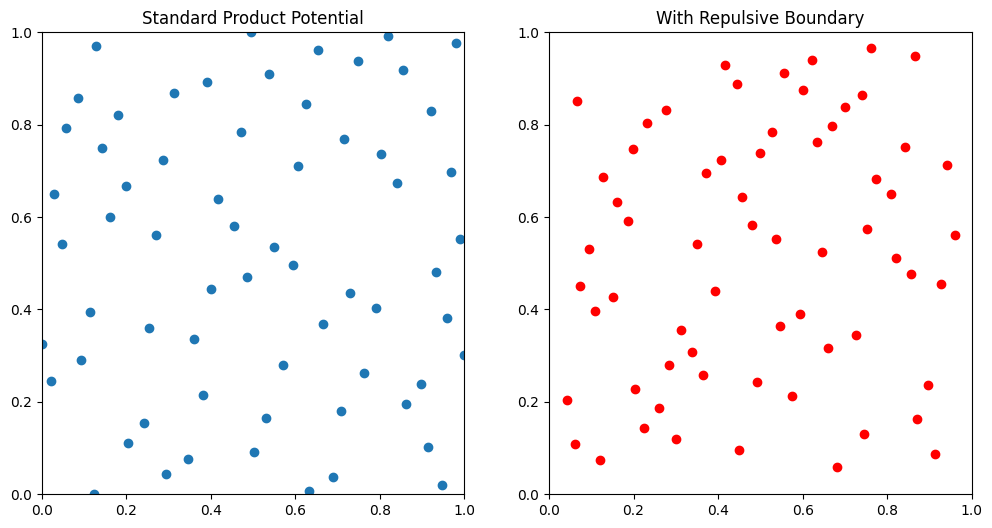

In [6]:
d = 2
n = 64

# Compare default vs repulsive boundary
opt_normal = ProductPotentialOptimizer(d, n, repulsive_boundary=False)
opt_repulse = ProductPotentialOptimizer(d, n, repulsive_boundary=True)

print("Optimizing Normal...")
X_normal = opt_normal.optimize()

print("Optimizing with Boundary Repulsion...")
X_repulse = opt_repulse.optimize()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].scatter(X_normal[:, 0], X_normal[:, 1])
axes[0].set_title("Standard Product Potential")
axes[0].set_xlim(0, 1); axes[0].set_ylim(0, 1)

axes[1].scatter(X_repulse[:, 0], X_repulse[:, 1], color='red')
axes[1].set_title("With Repulsive Boundary")
axes[1].set_xlim(0, 1); axes[1].set_ylim(0, 1)

plt.show()

## Discounted Potentials Comparison
Comparison of Optimized configurations using distance-discounted potentials:
1. **Exponential**: $e^{-C \|z\|}$
2. **Power Law**: $C \|z\|^{-\beta}$
3. **Logarithmic**: $C / \ln(e + \|z\|)$

where $\|z\|$ is the sum of coordinate distances normalized by box size.

Optimizing with discount_mode='exp'...
Optimizing with discount_mode='power'...
Optimizing with discount_mode='log'...


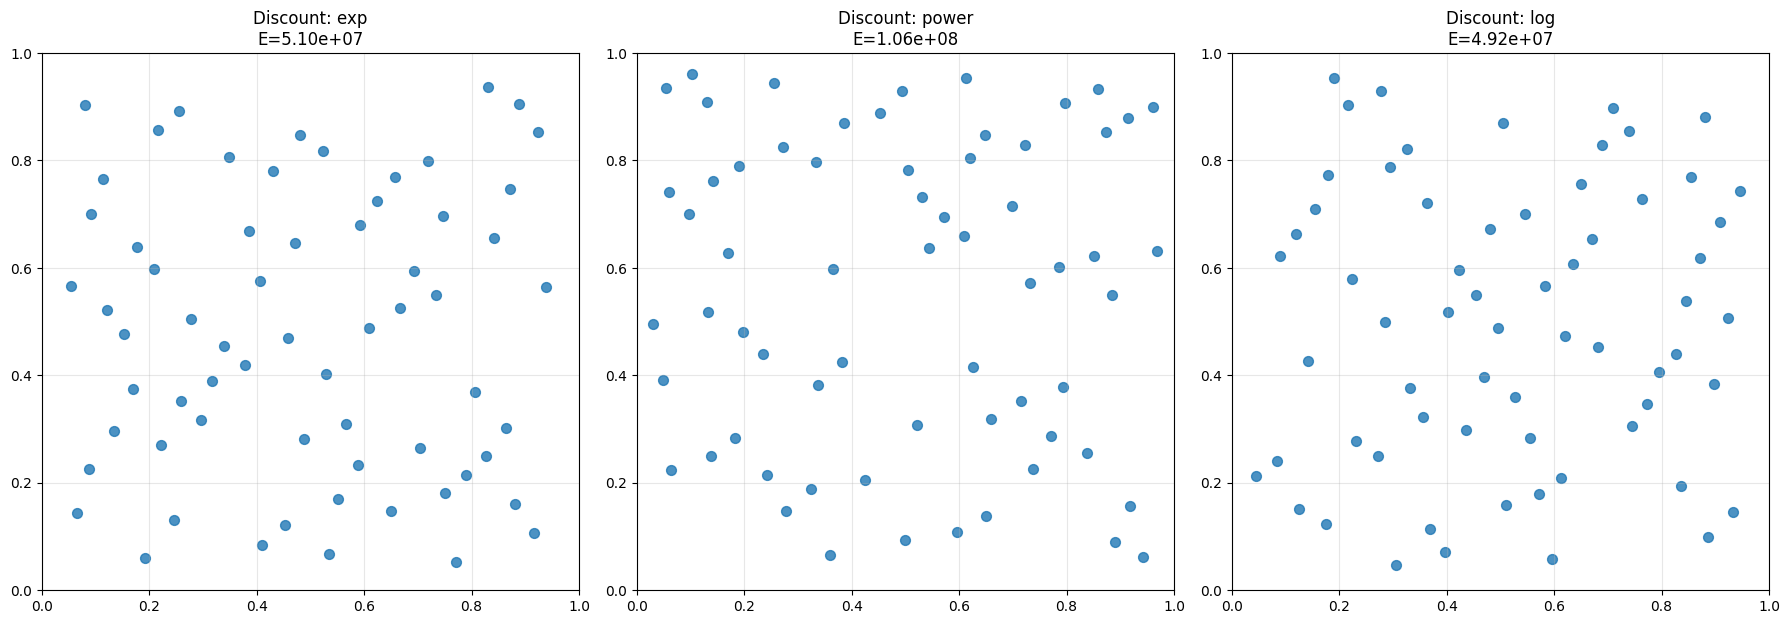

In [5]:
d = 2
n = 64
modes = ['exp', 'power', 'log']
beta = 1.0

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, mode in zip(axes, modes):
    print(f"Optimizing with discount_mode='{mode}'...")
    opt = ProductPotentialOptimizer(d, n, 
                                    repulsive_boundary=True, 
                                    discount_mode=mode, 
                                    discount_beta=beta)
    X_opt = opt.optimize(maxiter=1500)
    E = opt.compute_energy(X_opt.flatten())
    
    ax.scatter(X_opt[:, 0], X_opt[:, 1], s=50, alpha=0.8)
    ax.set_title(f"Discount: {mode}\nE={E:.2e}")
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()